In the previous two file, we covered the basics of PySpark, the MapReduce paradigm, transformations and actions, and how to do basic data cleanup in PySpark. In this challenge, we'll use the techniques we've learned to transform the text of Hamlet into a format that's more useful for data analysis.

Resources

* [PySpark's documentation for the RDD data structure](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD)
* [Visual representation of methods](http://nbviewer.ipython.org/github/jkthompson/pyspark-pictures/blob/master/pyspark-pictures.ipynb) (IPython Notebook format)
* [Visual representation of methods](https://training.databricks.com/visualapi.pdf) (PDF format)

The first value in each element (or line from the play) is a line number that identifies the line of the play the text is from. It appears in the following format:

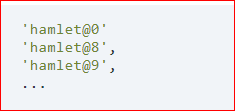

We don't need the hamlet@ at the beginning of these IDs for our data analysis. Let's extract just the integer part of the ID from each line, which is much more useful.

In [1]:
import pyspark

In [2]:
sc = pyspark.SparkContext()

In [3]:
raw_hamlet = sc.textFile("hamlet.txt")

In [6]:
split_hamlet = raw_hamlet.map(lambda line: line.split("\t"))
split_hamlet.take(5)

[['hamlet@0', '', 'HAMLET'],
 ['hamlet@8'],
 ['hamlet@9'],
 ['hamlet@10', '', 'DRAMATIS PERSONAE'],
 ['hamlet@29']]

In [12]:
def format_id(x):
    id = x[0].split("@")[1]
    results = list()
    results.append(id)
    if len(x) > 1:
        for y in x[1:]:
            results.append(y)
    return results

# or

# def format_id(line):
#     id = line[0].split("@")[1]
#     line[0] = id
#     return line
    

In [22]:
hamlet_with_ids = split_hamlet.map(lambda line:format_id(line))
print(hamlet_with_ids.take(5))

[['0', '', 'HAMLET'], ['8'], ['9'], ['10', '', 'DRAMATIS PERSONAE'], ['29']]


Next, we want to get rid of elements that don't contain any actual words (and just have an ID as the first value). These typically represent blank lines between paragraphs or sections in the play. We also want to remove any blank values ('') within elements, which don't contain any useful information for our analysis.

In [27]:
real_text = hamlet_with_ids.filter(lambda line:len(line) >1)
real_text.take(5)

[['0', '', 'HAMLET'],
 ['10', '', 'DRAMATIS PERSONAE'],
 ['31', 'CLAUDIUS', 'king of Denmark. (KING CLAUDIUS:)'],
 ['75', 'HAMLET', 'son to the late, and nephew to the present king.'],
 ['132', 'POLONIUS', 'lord chamberlain. (LORD POLONIUS:)']]

In [33]:
hamlet_text_only = real_text.map(lambda line: [i for i in line if i!=""])
hamlet_text_only.take(5)

[['0', 'HAMLET'],
 ['10', 'DRAMATIS PERSONAE'],
 ['31', 'CLAUDIUS', 'king of Denmark. (KING CLAUDIUS:)'],
 ['75', 'HAMLET', 'son to the late, and nephew to the present king.'],
 ['132', 'POLONIUS', 'lord chamberlain. (LORD POLONIUS:)']]

If we've been using take() to preview the RDD after each task, we may have noticed there are some pipe characters (|) in odd places that add no value for us. The pipe character may appear as a standalone value in an element, or as part of an otherwise useful string value.

In [34]:
hamlet_text_only.take(10)

[['0', 'HAMLET'],
 ['10', 'DRAMATIS PERSONAE'],
 ['31', 'CLAUDIUS', 'king of Denmark. (KING CLAUDIUS:)'],
 ['75', 'HAMLET', 'son to the late, and nephew to the present king.'],
 ['132', 'POLONIUS', 'lord chamberlain. (LORD POLONIUS:)'],
 ['177', 'HORATIO', 'friend to Hamlet.'],
 ['204', 'LAERTES', 'son to Polonius.'],
 ['230', 'LUCIANUS', 'nephew to the king.'],
 ['261', 'VOLTIMAND', '|'],
 ['273', '|']]

Remove any list items that only contain the pipe character (|), and replace any pipe characters that appear within strings with an empty character.

In [35]:
clean_hamlet = hamlet_text_only.map(lambda line: [l for l in line if l != "|"])
clean_hamlet.take(10)

[['0', 'HAMLET'],
 ['10', 'DRAMATIS PERSONAE'],
 ['31', 'CLAUDIUS', 'king of Denmark. (KING CLAUDIUS:)'],
 ['75', 'HAMLET', 'son to the late, and nephew to the present king.'],
 ['132', 'POLONIUS', 'lord chamberlain. (LORD POLONIUS:)'],
 ['177', 'HORATIO', 'friend to Hamlet.'],
 ['204', 'LAERTES', 'son to Polonius.'],
 ['230', 'LUCIANUS', 'nephew to the king.'],
 ['261', 'VOLTIMAND'],
 ['273']]

In [42]:
def fix_pipe(line):
    results = list()
    for l in line:
        if l == "|":
            pass
        elif "|" in l:
            fmtd = l.replace("|", "")
            results.append(fmtd)
        else:
            results.append(l)
    return results

# or

# def fix_pipe(line):
#     for i in range(len(line)):
#         if "|" in line[i]:
#                    line[i] = line[i].replace("|","")
#     return line           

In [45]:
clean_hamlet = hamlet_text_only.map(lambda line: fix_pipe(line))      